In [281]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [282]:
data_path = "/content/drive/MyDrive/COMP 4332/data"

In [283]:
from collections import Counter
from itertools import combinations
import random
import numpy as np
import pandas as pd
import tensorflow
from tensorflow.keras.layers import Concatenate, Dense, Dot, Dropout, Embedding, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers
import os

# Setting random seeds to replicate results easily
random.seed(0)
np.random.seed(0)
tensorflow.random.set_seed(0)

# Wide and Deep Learning (WDL) Model Implementation


In [284]:
def build_wdl_model(len_continuous, deep_vocab_lens, len_wide, embed_size):
    """
    Wide component is normally for memorization
    Deep component is normally for generalization
    params:
      len_continuous: number of continuous features
      deep_vocab_lens: an array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
      len_wide: number of wide features
      embed_size: dimension of the embedding vectors of deep categorical features

    return:
      a keras Model object for the constructed wdl model
    """
    # A list containing all input layers
    input_list = []

    # Input layer for continuous features
    continuous_input = Input(shape=(len_continuous,), dtype='float32', name='continuous_input')
    input_list.append(continuous_input)

    # Get embeddings for all deep categorical features
    emb_list = []
    for vocab_size in deep_vocab_lens:
        _input = Input(shape=(1,), dtype='int32')
        input_list.append(_input)
        _emb = Embedding(output_dim=embed_size, input_dim=vocab_size, input_length=1)(_input)
        _emb = Reshape((embed_size,))(_emb)
        emb_list.append(_emb)

    # Create input layer for deep component by concatenating the embeddings and continuous features' input layer
    deep_input = Concatenate()(emb_list + [continuous_input])

    # Construct deep component
    dense_1 = Dense(256, activation='relu')(deep_input)
    dense_1_dp = Dropout(0.2)(dense_1)
    dense_2 = Dense(128, activation='relu')(dense_1_dp)
    dense_2_dp = Dropout(0.2)(dense_2)
    dense_3 = Dense(64, activation='relu')(dense_2_dp)
    dense_3_dp = Dropout(0.2)(dense_3)
    dense_4 = Dense(64, activation='relu')(dense_3_dp)
    dense_4_dp = Dropout(0.2)(dense_4)
    # dense_5 = Dense(32, activation='relu')(dense_4_dp)
    # dense_5_dp = Dropout(0.2)(dense_5)

    # Create input layer for wide component
    wide_input = Input(shape=(len_wide,), dtype='float32')
    input_list.append(wide_input)

    # Concatenate the outputs of deep and wide components and feed the concatenated vector into the finall fully connected layer
    fc_input = Concatenate()([dense_3_dp, wide_input])
    model_output = Dense(1)(fc_input)

    model = Model(inputs=input_list, outputs=model_output)
    return model

# Data Preprocessing


In [285]:
def get_continuous_features(df, continuous_columns):
    '''
    params:
        df: input dataframe
        continuous_columns: column names of continuous features

    return:
        a numpy array where each row contains the values of continuous features in the corresponding row of the input dataframe
    '''
    continuous_features = df[continuous_columns].values
    return continuous_features

In [286]:
def get_top_k_p_combinations(df, comb_p, topk, output_freq=False):
    '''
    params:
        df: input dataframe
        comb_p: number of elements in each combination (e.g., there are two elements in the combination {fried chicken, chicken and waffle}, and three elements in the combination {fried chicken, chicken and waffle, chicken fried rice})
        topk: number of most frequent combinations to retrieve
        output_freq: whether to return the frequencies of retrieved combinations

    return:
        1. output_freq = True: a list X where each element is a tuple containing a combination tuple and corresponding frequency, and the elements are stored in the descending order of their frequencies
        2. output_freq = False: a list X where each element is a tuple containing a combination tuple, and the elements are stored in the descending order of their frequencies
    '''
    def get_category_combinations(categories, comb_p=2):
        if isinstance(categories, (float, int)) and math.isnan(categories):
          categories = []
        return list(combinations(categories, comb_p))
    all_categories_p_combos = df["category"].apply(lambda x: get_category_combinations(x, comb_p)).values.tolist()
    all_categories_p_combos = [tuple(t) for item in all_categories_p_combos for t in item]
    tmp = dict(Counter(all_categories_p_combos))
    sorted_categories_combinations = list(sorted(tmp.items(), key=lambda x: x[1], reverse=True))
    if output_freq:
        return sorted_categories_combinations[:topk]
    else:
        return [t[0] for t in sorted_categories_combinations[:topk]]

### Building Wide Features

In [287]:
def get_wide_features(df, selected_categories_to_idx, top_combinations):
    '''
    params:
        df: input dataframe
        selected_categories_to_idx: a dictionary mapping item categories to corrresponding integral indices
        top_combinations: a list containing retrieved mostly frequent combinantions of item categories

    return:
        a numpy array where each row contains the categorical features' binary encodings and cross product transformations for the corresponding row of the input dataframe
    '''
    def categories_to_binary_output(categories):
        if isinstance(categories, (float, int)) and math.isnan(categories):
          categories = []
        binary_output = [0 for _ in range(len(selected_categories_to_idx))]
        for category in categories:
            if category in selected_categories_to_idx:
                binary_output[selected_categories_to_idx[category]] = 1
            else:
                binary_output[0] = 1
        return binary_output
    def categories_cross_transformation(categories):
        if isinstance(categories, (float, int)) and math.isnan(categories):
          categories = []
        current_category_set = set(categories)
        corss_transform_output = [0 for _ in range(len(top_combinations))]
        for k, comb_k in enumerate(top_combinations):
            if len(current_category_set & comb_k) == len(comb_k):
                corss_transform_output[k] = 1
            else:
                corss_transform_output[k] = 0
        return corss_transform_output

    category_binary_features = np.array(df.category.apply(lambda x: categories_to_binary_output(x)).values.tolist())
    print('category_cross_features shape:',category_binary_features.shape)
    category_cross_transform_features = np.array(df.category.apply(lambda x: categories_cross_transformation(x)).values.tolist())
    print('category_cross_features shape:',category_cross_transform_features.shape)
    print('wide features shape:',np.concatenate((category_binary_features, category_cross_transform_features), axis=1).shape)

    return np.concatenate((category_binary_features, category_cross_transform_features), axis=1)

# Ratings Prediction

### Loading train, validation and test rating tables

In [288]:
tr_df = pd.read_csv(data_path+"/review.csv")
val_df = pd.read_csv(data_path+"/validation.csv")
te_df = pd.read_csv(data_path+"/prediction.csv")

In [289]:
train_products = tr_df["ProductID"].unique()
train_users = tr_df["ReviewerID"].unique()

row_to_drop_in_val = []
for index, row in val_df.iterrows():
    if row["ProductID"] not in train_products or row["ReviewerID"] not in train_users:
        tr_df = tr_df._append(row, ignore_index=True)
        row_to_drop_in_val.append(index)

val_df = val_df.drop(row_to_drop_in_val)

train_products = tr_df["ProductID"].unique()
train_users = tr_df["ReviewerID"].unique()

cnt = 0
for row in te_df.iterrows():
    if row[1]["ProductID"] not in train_products and row[1]["ReviewerID"] not in train_users:
        print(cnt, row[1]["ProductID"], row[1]["ReviewerID"])
        cnt += 1
cnt


0

### Building two dictionaries to map original user ids and item ids into corresponding indices in respective embedding matrices

In [290]:
# Get the unique set of all user ids and set of all business ids in train set
user_set = set(tr_df.ReviewerID.unique())
business_set = set(tr_df.ProductID.unique())

# Build user vocabulary
user_vocab = dict(zip(user_set, range(1, len(user_set) + 1)))

# Reserve the first row of the embedding matrix for users unseen in the training set
user_vocab['unk'] = 0
n_users = len(user_vocab)

# Build business vocabulary
business_vocab = dict(zip(business_set, range(1, len(business_set) + 1)))
# Reserve the first row of the embedding matrix for businesses unseen in the training set
business_vocab['unk'] = 0
n_items = len(business_vocab)

### Loading content feautures tables of users and items

In [291]:
print(tr_df.shape)
print(val_df.shape)
print(te_df.shape)

(54014, 5)
(5094, 3)
(6633, 3)


In [292]:
# Read the JSON file
import json
with open(data_path+"/product.json", "r") as file:
    product_json = json.load(file)
# Replace empty strings with None (null) in all columns
for product in product_json:
    for key, value in product.items():
        if value == "" or value == []:
            product[key] = None
# Convert back to JSON string
updated_product_json= json.dumps(product_json)
# Convert the JSON data to a dataframe
product_df = pd.json_normalize(product_json) # deal with more complex nested json structure than pd.DataFrame()

### Replacing the original user and item ids in train and valdiation set with indices in embedding matrices

In [293]:
# Transforming user_id into a number by the user_vocab dictionary, and
# transforming business_id into a number by the business_vocab dictonary
tr_df["ReviewerID"] = tr_df["ReviewerID"].apply(lambda x: user_vocab[x])
tr_df["ProductID"] = tr_df["ProductID"].apply(lambda x: business_vocab[x])
product_df["ProductID"] = product_df["ProductID"].apply(lambda x: business_vocab[x] if x in business_vocab else 0)
val_df["ReviewerID"] = val_df["ReviewerID"].apply(lambda x: user_vocab[x] if x in user_vocab else 0)
val_df["ProductID"] = val_df["ProductID"].apply(lambda x: business_vocab[x] if x in business_vocab else 0)
te_df["ReviewerID"] = te_df["ReviewerID"].apply(lambda x: user_vocab[x] if x in user_vocab else 0)
te_df["ProductID"] = te_df["ProductID"].apply(lambda x: business_vocab[x] if x in business_vocab else 0)

In [294]:
# remove the unit from some of the continuous data
product_df['details.File Size:'] = pd.to_numeric(product_df['details.File Size:'].apply(lambda x: str(float(x[:-2]) * 1024) + ' KB' if x.endswith('MB') else x) #change units from mb to kb
                                    .str.replace(' KB', '').str.replace(' kB', '')) #ignore the unit kb
product_df['details.Print Length:'] = pd.to_numeric(product_df['details.Print Length:'].str.replace(' pages', ''))
#separate the rank int free rank and paid rank
product_df['Free rank'] = product_df['rank'].str.extract(r'([\d,]+) Free in Kindle Store')
product_df['Free rank'] = product_df['Free rank'].apply(lambda x: float(str(x).replace(',', '')) if x  else x)
product_df['Paid rank'] = product_df['rank'].str.extract(r'([\d,]+) Paid in Kindle Store')
product_df['Paid rank'] = product_df['Paid rank'].apply(lambda x: float(str(x).replace(',', '')) if x  else x)
#product_df = product_df.drop('rank', axis=1)
product_df['rank'] = product_df['Free rank'].combine_first(product_df['Paid rank'])
print(product_df.shape)
# remove the publisher date included in the field details.Publisher:
import re
product_df['details.Publisher:'] = product_df['details.Publisher:'].apply(lambda x: re.search(r'^(.*?) \(.*', str(x)).group(1) if re.search(r'^(.*?) \(.*', str(x)) else 'Unknown')

# drop these columns with most rows without data
product_df.drop(["price", "details.Release Date:",	"details.ISBN-10:",	"details.ISBN-13:", "details.Page Numbers Source ISBN:"], axis=1, inplace=True)
print(product_df.shape)

product_df.dropna(axis=1, how='all', inplace=True)
print(product_df.shape)

# drop the column which all rows have same value
product_df.drop(["main_cat"], axis=1, inplace=True)
print(product_df.shape)

# Delete rows with NaN values in the specified column as I don't know how to deal with them
product_df = product_df.dropna(subset=["rank","details.Print Length:"])
# Define the string to remove
string_to_remove_1 = 'Kindle Store'
string_to_remove_2 = '</span>'
# Apply the lambda function to remove the string from each list
product_df['category'] = product_df['category'].apply(lambda x: [item for item in x if item != string_to_remove_1 and item != string_to_remove_2])
# Try to add publisher as a wide features
product_df['category'] = product_df['category'].apply(lambda x: [item for item in x if item != string_to_remove_1 and item != string_to_remove_2])

user_df = pd.DataFrame(tr_df.groupby('ReviewerID')['Star'].agg(['count', 'mean'])).reset_index()
user_df.columns = ['ReviewerID', 'reviewer_review_count', 'reviewer_avg_star']
product_avg_star_df = pd.DataFrame(tr_df.groupby('ProductID')['Star'].agg(['count', 'mean'])).reset_index()
product_avg_star_df.columns = ['ProductID', 'product_review_count','product_avg_star']
print(user_df)
print(product_avg_star_df)



(6309, 31)
(6309, 26)
(6309, 17)
(6309, 16)
      ReviewerID  reviewer_review_count  reviewer_avg_star
0              1                     32           4.875000
1              2                     14           4.285714
2              3                     52           3.076923
3              4                     22           4.227273
4              5                      7           5.000000
...          ...                    ...                ...
2794        2795                     21           5.000000
2795        2796                     15           2.800000
2796        2797                      3           2.333333
2797        2798                      3           5.000000
2798        2799                      3           4.666667

[2799 rows x 3 columns]
      ProductID  product_review_count  product_avg_star
0             1                     2          5.000000
1             2                     3          5.000000
2             3                     8          4.375000

<ipython-input-294-3aa02a3e0a4c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df['category'] = product_df['category'].apply(lambda x: [item for item in x if item != string_to_remove_1 and item != string_to_remove_2])
<ipython-input-294-3aa02a3e0a4c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_df['category'] = product_df['category'].apply(lambda x: [item for item in x if item != string_to_remove_1 and item != string_to_remove_2])


In [295]:
tr_df = pd.merge(pd.merge(pd.merge(tr_df, product_df, on='ProductID', how='left') # exclude those review without product information
                ,product_avg_star_df, on='ProductID', how='left')
                ,user_df, on='ReviewerID', how='left').reset_index(drop=True)
val_df = pd.merge(pd.merge(pd.merge(val_df, product_df, on='ProductID', how='left')
                ,product_avg_star_df, on='ProductID', how='left')
                ,user_df, on='ReviewerID', how='left').reset_index(drop=True)
te_df = pd.merge(pd.merge(pd.merge(te_df, product_df, on='ProductID', how='left')
                ,product_avg_star_df, on='ProductID', how='left')
                ,user_df, on='ReviewerID', how='left').reset_index(drop=True)

In [296]:
print(tr_df.ReviewerID)
print(val_df.shape)
print(te_df.shape)
print(tr_df.ReviewerID)


0          52
1        2202
2         774
3        1057
4        1595
         ... 
54009    1903
54010     173
54011     634
54012    2020
54013     816
Name: ReviewerID, Length: 54014, dtype: int64
(5094, 22)
(6633, 22)
0          52
1        2202
2         774
3        1057
4        1595
         ... 
54009    1903
54010     173
54011     634
54012    2020
54013     816
Name: ReviewerID, Length: 54014, dtype: int64


### Expanding the table by using user_id and business_id
Expanding the train, valiation and test dataset by using `ReviewerID` and `ProductID` to query more features from `user_df` (which contain only the average stars given by and the number of reviews written by each reviewer) and `product_avg_star_df` and `product_df`.

In [297]:
print(tr_df.shape)
print(val_df.shape)
print(te_df.shape)

(54014, 24)
(5094, 22)
(6633, 22)


In [298]:
# labels for training and validation
tr_ratings = tr_df['Star'].values
val_ratings = val_df['Star'].values

In [299]:
tr_df.head()

,ReviewerID,ProductID,Text,Summary,Star,category,title,brand,rank,details.File Size:,...,details.ASIN:,details.Word Wise:,details.Lending:,details.Simultaneous Device Usage:,Free rank,Paid rank,product_review_count,product_avg_star,reviewer_review_count,reviewer_avg_star
0,52,1384,Liked the movie. Loved the book. It really giv...,Liked the movie. Loved the book!,5.0,"[Kindle eBooks, Biographies & Memoirs]",None,Visit Amazon's Frank W. Abagnale Page,59404.0,1466.0,...,B000FBFMHU,Enabled,Enabled,NaN,NaN,59404.0,1,5.000000,13,2.461538
1,2202,2039,Purchased more out of curiosity than any real ...,"Not my favorite, but...",3.0,"[Kindle eBooks, Politics & Social Sciences]",None,Visit Amazon's Karl Marx Page,1358073.0,142.0,...,B000FC27TA,Enabled,Not Enabled,NaN,NaN,1358073.0,2,3.500000,71,3.830986
2,774,2039,"I actually received this text as an ebook, sin...",An interesting read,4.0,"[Kindle eBooks, Politics & Social Sciences]",None,Visit Amazon's Karl Marx Page,1358073.0,142.0,...,B000FC27TA,Enabled,Not Enabled,NaN,NaN,1358073.0,2,3.500000,8,4.500000
3,1057,1621,REVIEWER'S OPINION:\nThis was labeled as roman...,This was labeled romance but there was less ro...,2.0,"[Kindle eBooks, Romance]",None,Visit Amazon's Allison Brennan Page,94006.0,739.0,...,B000FCKPG2,Enabled,Not Enabled,NaN,NaN,94006.0,1,2.000000,24,2.625000
4,1595,3416,I have been saving the Argeneau novels for awh...,Science Fiction not Paranormal Romance,2.0,"[Kindle eBooks, Mystery, Thriller &amp; Suspense]",None,Visit Amazon's Lynsay Sands Page,31652.0,1011.0,...,B000GCFWXW,Enabled,Not Enabled,NaN,NaN,31652.0,7,3.142857,19,2.947368


In [300]:
tr_df.shape

(54014, 24)

In [301]:
#tr_df.to_csv(data_path+'/my_train.csv', index=False)

### Preparing continuous features

In [302]:
# Specify the columns containing conitnuous features

continuous_columns = ["rank",
                      "reviewer_avg_star", "product_avg_star"]


# Assuming you have a DataFrame called 'df' and a list of column names to fill nan with medians
def fill_nan_with_median(df, columns_to_fill ):
  for column in columns_to_fill:
      median_value = df[column].median()
      df[column].fillna(median_value, inplace=True)
  return df

tr_df = fill_nan_with_median(tr_df, continuous_columns)
val_df = fill_nan_with_median(val_df, continuous_columns)
te_df = fill_nan_with_median(te_df, continuous_columns)

# Get values of continous features for train/validation/test sets using the utility function defined previously
tr_continuous_features = get_continuous_features(tr_df, continuous_columns)
val_continuous_features = get_continuous_features(val_df, continuous_columns)
te_continuous_features = get_continuous_features(te_df, continuous_columns)

# Standardize each feature by removing the mean of the training samples and scaling to unit variance.
# See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html for more details.
scaler = StandardScaler().fit(tr_continuous_features)

tr_continuous_features = scaler.transform(tr_continuous_features)
val_continuous_features = scaler.transform(val_continuous_features)
te_continuous_features = scaler.transform(te_continuous_features)

<ipython-input-302-4dc0772c8938>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


### Preparing deep categorical features

In [303]:
# Sepcify column names of deep categorical features
item_deep_columns = ["brand", "details.Language:", "details.Word Wise:", "details.Lending:","details.Publisher:"]
product_df = product_df.fillna({col: 'unknown' for col in item_deep_columns})

# An array of integers where deep_vocab_lens[i] represents the number of unique values of (i+1)-th deep categorical feature
# Transforming words into indices for each categorical columns
item_deep_vocab_lens = []
for col_name in item_deep_columns:
    # Getting unique values of this deep categorical feature
    unique_values = product_df[col_name].unique()

    # Creating a dictionary to map from unique values to the corresponding index
    vocab = dict(zip(unique_values, range(1, len(unique_values)+1)))

    # Getting the number of unique values of this deep categorical features
    item_deep_vocab_lens.append(len(vocab)+1)

    # Creating a new column where each entry stores the index of this deep categorical feature's value in the same row
    product_df[col_name + "_idx"] = product_df[col_name].apply(lambda x: vocab[x])


# Creating a dictionary mapping each business id to corresponding values of deep categorical features ('business_id' -> ['item_city_idx', 'item_postal_code_idx', 'item_state_idx'] in this case)
item_deep_idx_columns = [t + "_idx" for t in item_deep_columns]
item_to_deep_categorical_features = dict(zip(product_df['ProductID'].values, product_df[item_deep_idx_columns].values.tolist()))

# Creating numpy arrays storing corresponding deep categorical features' values of train/validation/test sets using the above mapping
tr_deep_categorical_features = np.array(tr_df['ProductID'].apply(lambda x: item_to_deep_categorical_features[x] if x in item_to_deep_categorical_features else np.zeros(5, dtype=int)).values.tolist())
val_deep_categorical_features = np.array(val_df['ProductID'].apply(lambda x: item_to_deep_categorical_features[x] if x in item_to_deep_categorical_features else np.zeros(5, dtype=int)).values.tolist())
te_deep_categorical_features = np.array(te_df['ProductID'].apply(lambda x: item_to_deep_categorical_features[x] if x in item_to_deep_categorical_features else np.zeros(5, dtype=int)).values.tolist())

### Preparing wide features

##### Preparing binary encoding for each selected category

In [304]:
# Collect the categories of all items
all_categories = [category for category_list in product_df.category.values for category in category_list]
print(all_categories)
# Sort all unique values of the item categories by their frequencies in descending order
category_sorted = sorted(Counter(all_categories).items(), key=lambda x: x[1], reverse=True)

# Select top 500 most frequent categories
selected_categories = [t[0] for t in category_sorted[:500]]
#selected_categories = [t[0] for t in len(category_sorted)]

# Create a dictionary mapping each secleted category to a unique integral index
selected_categories_to_idx = dict(zip(selected_categories, range(1, len(selected_categories) + 1)))

# Map all categories unseen in the item df to index 0
selected_categories_to_idx['unk'] = 0

# Create a dictionary mapping each integral index to corresponding category
idx_to_selected_categories = {val: key for key, val in selected_categories_to_idx.items()}
print(len(category_sorted))

['Kindle eBooks', 'Biographies & Memoirs', 'Kindle eBooks', 'Politics & Social Sciences', 'Kindle eBooks', 'Romance', 'Kindle eBooks', 'Mystery, Thriller &amp; Suspense', 'Kindle eBooks', 'Romance', 'Kindle eBooks', 'Religion &amp; Spirituality', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Health, Fitness & Dieting', 'Kindle eBooks', 'Mystery, Thriller &amp; Suspense', 'Kindle eBooks', 'Romance', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', "Children's eBooks", 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Religion & Spirituality', 'Kindle eBooks', 'Literature & Fiction', 'Kindle eBooks', 'Mystery, Thriller & Suspense', 'Kindle eBooks', 'Religion & Spirituality', 'Kindle eBooks', "Children's eBooks", 'Kindle eBooks', 'Literature & Fiction', 'Ki

##### Preparing cross product transformation for categories

In [305]:
# Get most frequent categories combinantions using the utility function defined previously and store them in the folloing list
top_combinations = []

# Get top 50 most frequent two-categories combinantions in the train set

top_combinations += get_top_k_p_combinations(tr_df, 2, 50, output_freq=False)

# Get top 30 most frequent three-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 3, 30, output_freq=False)

# Get top 20 most frequent four-categories combinantions in the train set
top_combinations += get_top_k_p_combinations(tr_df, 4, 20, output_freq=False)

# Convert each combinantion in the list to a set data structure
top_combinations = [set(t) for t in top_combinations]
print(top_combinations)

[{'Kindle eBooks', 'Literature & Fiction'}, {'Kindle eBooks', 'Romance'}, {'Kindle eBooks', 'Mystery, Thriller & Suspense'}, {'Science Fiction & Fantasy', 'Kindle eBooks'}, {'Religion & Spirituality', 'Kindle eBooks'}, {'Kindle eBooks', 'Teen & Young Adult'}, {"Children's eBooks", 'Kindle eBooks'}, {'Kindle eBooks', 'Health, Fitness & Dieting'}, {'Kindle eBooks', 'Business & Money'}, {'Cookbooks, Food & Wine', 'Kindle eBooks'}, {'Humor & Entertainment', 'Kindle eBooks'}, {'Biographies & Memoirs', 'Kindle eBooks'}, {'Politics & Social Sciences', 'Kindle eBooks'}, {'Kindle eBooks', 'Literature &amp; Fiction'}, {'Kindle eBooks', 'Reference'}, {'Kindle eBooks', 'Crafts, Hobbies & Home'}, {'Kindle eBooks', 'History'}, {'Kindle eBooks', 'Arts & Photography'}, {'Kindle eBooks', 'Computers & Technology'}, {'Science & Math', 'Kindle eBooks'}, {'Self-Help', 'Kindle eBooks'}, {'Education & Teaching', 'Kindle eBooks'}, {'Parenting & Relationships', 'Kindle eBooks'}, {'Kindle eBooks', 'Comics, Mang

In [306]:
# Getting values of wide features for train/validation/test sets using the utility function defined previously
# The following matrices should have a shape of (n_samples, len(selected_categories_to_idx)+len(top_combinations))
tr_wide_features = get_wide_features(tr_df, selected_categories_to_idx, top_combinations)
val_wide_features = get_wide_features(val_df, selected_categories_to_idx, top_combinations)
te_wide_features = get_wide_features(te_df, selected_categories_to_idx, top_combinations)

category_cross_features shape: (54014, 36)
category_cross_features shape: (54014, 33)
wide features shape: (54014, 69)
category_cross_features shape: (5094, 36)
category_cross_features shape: (5094, 33)
wide features shape: (5094, 69)
category_cross_features shape: (6633, 36)
category_cross_features shape: (6633, 33)
wide features shape: (6633, 69)


### Concatenating continuous features, deep categorical features and wide features as an input list

In [307]:
tr_features = []
tr_features.append(tr_continuous_features) #(no.of samples, no. of continuous features 7)
tr_features += [tr_deep_categorical_features[:, i] for i in range(tr_deep_categorical_features.shape[1])]  #(no.of samples, no. of categorical features 5)
tr_features.append(tr_wide_features)  #(no.of samples, no. of continuous features 68)

val_features = []
val_features.append(val_continuous_features)
val_features += [val_deep_categorical_features[:, i] for i in range(val_deep_categorical_features.shape[1])]
val_features.append(val_wide_features)

te_features = []
te_features.append(te_continuous_features)
te_features += [te_deep_categorical_features[:, i] for i in range(te_deep_categorical_features.shape[1])]
te_features.append(te_wide_features)
print(len(tr_wide_features))

54014


In [308]:
print(tr_features)

[array([[-0.58450018, -2.99486395,  1.52205934],
       [ 3.45166876, -0.77038393, -1.76416274],
       [ 3.45166876,  0.31633792, -1.76416274],
       ...,
       [-0.30213254, -0.91959059, -0.66875538],
       [-0.75884869,  1.12851951,  0.97435566],
       [-0.30213254, -1.25001229, -0.66875538]]), array([  1,   2,   2, ...,   0, 804,   0]), array([1, 1, 1, ..., 0, 1, 0]), array([1, 1, 1, ..., 0, 1, 0]), array([1, 2, 2, ..., 0, 2, 0]), array([ 1,  2,  2, ...,  0, 26,  0]), array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])]


### Building the WDL

In [309]:
from math import sqrt

import pandas as pd
from sklearn.metrics import (accuracy_score, mean_squared_error,
                             precision_recall_fscore_support)


# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))




In [310]:
wdl_model = build_wdl_model(len(tr_continuous_features[0]), item_deep_vocab_lens,  len(tr_wide_features[0]), embed_size=100)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [311]:
val_features[0].shape

(5094, 3)

### Train the model using Adagrad optimizer and mean squared error loss

In [312]:
#wdl_model.compile(optimizer='adagrad', loss='mse')
def root_mean_squared_error(y_true, y_pred):
      mask = tensorflow.not_equal(y_true, 0)
      pred = tensorflow.boolean_mask(y_pred, mask)
      actual = tensorflow.boolean_mask(y_true, mask)
      return tensorflow.sqrt(tensorflow.reduce_mean(tensorflow.square(y_pred - y_true)))
wdl_model.compile(optimizer='adagrad', loss=root_mean_squared_error)
# save_dir = os.path.join(os.getcwd(), "save_models")
# filepath = "cnn_cnn_weights.{epoch:02d}-{val_loss:.4f}--0fold.tf"
# checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath),
#                              monitor="val_loss", verbose=1, save_best_only=False, mode='min')
os.chdir('/content/drive/My Drive/COMP 4332/data')
save_dir = os.path.join(os.getcwd(), "save_models")
filepath = "cnn_cnn_weights.{epoch:02d}-{val_loss:.4f}--0fold.keras"
checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath))
history = wdl_model.fit(

        tr_features,
        tr_ratings,
        batch_size=1000,
        epochs = 120,
        validation_data=[val_features, val_ratings], validation_batch_size=32, verbose=1)
        #validation_data=[val_features, val_ratings], validation_batch_size=val_features[0].shape, verbose=1, callbacks=[ModelCheckpoint('models/model.h5')])

# # Ensure inputs are NumPy arrays (not Pandas DataFrames)
# tr_features = np.array(tr_features)
# tr_ratings = np.array(tr_ratings)
# val_features = np.array(val_features)
# val_ratings = np.array(val_ratings)

# # Proceed with training
# history = wdl_model.fit(
#     tr_features,
#     tr_ratings,
#     batch_size=1000,
#     epochs=120,
#     validation_data=(val_features, val_ratings),  # Note: tuple, not list
#     validation_batch_size=32,
#     verbose=1,
#     callbacks=[ModelCheckpoint('models/model.h5')]
# )

Epoch 1/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 4.1890 - val_loss: 3.9712
Epoch 2/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.0533 - val_loss: 3.8330
Epoch 3/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 3.9090 - val_loss: 3.6561
Epoch 4/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 3.7198 - val_loss: 3.4067
Epoch 5/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 3.4465 - val_loss: 3.0261
Epoch 6/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 3.0219 - val_loss: 2.3861
Epoch 7/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.2955 - val_loss: 1.3242
Epoch 8/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 1.3210 - val_loss: 0.8886
Epoch 9/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1.0682 - val_loss: 0.8880
Epoch 10/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.0504 - val_loss: 0.8846
Epoch 11/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1.0411 - val_loss: 0.8841
Epoch 12/120
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step

### Evaluate the model on train and validation sets using RMSE¶

In [313]:
y_pred = wdl_model.predict(tr_features)
print("TRAIN RMSE: ", rmse(y_pred, tr_ratings))
y_pred = wdl_model.predict(val_features)
print("VALID RMSE: ", rmse(y_pred, val_ratings))

1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
TRAIN RMSE:  0.6599457513833752
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
VALID RMSE:  0.8641516090902193


In [314]:

if __name__ == "__main__":

    print("VALID RMSE: ", rmse(y_pred, val_ratings))


VALID RMSE:  0.8641516090902193


dict_keys(['loss', 'val_loss'])


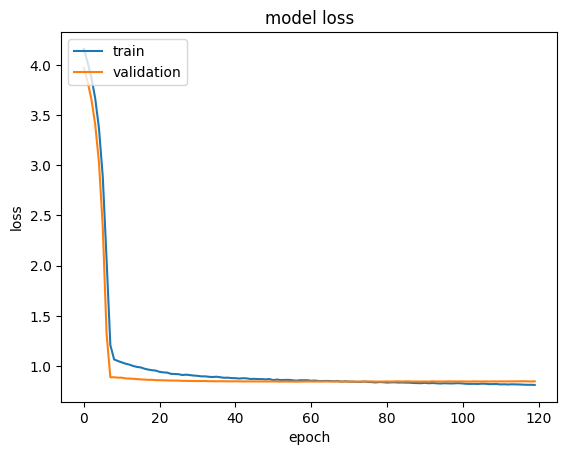

In [317]:
import matplotlib.pyplot as plt
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()